In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import load_disaster_point_data, load_synthetic_non_disaster_points, load_grid_point_data

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers, prediction_to_gpd_df , set_plotting_data, add_data, add_country_effect
from laos_gggi.data_functions.combine_data import load_all_data
from pymc.model.transform.optimization import freeze_dims_and_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load


from laos_gggi.transformers import CenterTransform, Standardize

configure_plot_style()

# Load and prepare data

In [6]:
world = load_shapefile('world')
# rivers = load_rivers_data()
laos = world.query('ISO_A3 == "LAO"')

# Select SEA shape
laos_neighboors = [
    "MMR",  # Myanmar
    "THA",  # Thailand
    "LAO",  # Laos
    "KHM",  # Cambodia
    "VNM",  # Vietnam
    "IDN",  # Indonesia
    "MYS",  # Malaysia
    "SGP",  # Singapore
    "PHL",  # Philippines
    "BRN",  # Brunei
    "TLS"   # Timor-Leste
]
sea_map = world.query('ISO_A3 in @laos_neighboors')

In [7]:
sea_point_grid = load_grid_point_data(region='sea', grid_size=400, force_reload = True )
laos_point_grid = load_grid_point_data(region='laos', grid_size=100)

Loading shapefiles and rivers data
Computing point grid and features


Calculating distances to rivers:   0%|          | 0/30496 [00:00<?, ?it/s]

Calculating distances to coastline:   0%|          | 0/30496 [00:00<?, ?it/s]

C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\laos_gggi\data_functions\disaster_point_data.py:218: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(fpath)
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'distance_to_river' to 'distance_t'
  ogr_write(
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'distance_to_coastline' to 'distance_1'
  ogr_write(
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'log_distance_to_river' to 'log_distan'
  ogr_write(
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'log_distance_to_coastline' to 'log_dist_1'
  ogr_wr

In [5]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip']]
co2 = all_data["df_time_series"]["co2"]

In [6]:
disasters = load_disaster_point_data()
not_disasters = load_synthetic_non_disaster_points(by='country', multiplier=3)

merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\synthetic_non_disasters_country_times_3.csv


In [7]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [8]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [9]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])

#Creating the squared log variables
df["log_population_density_squared"] = 2 * df["log_population_density"]
df["log_gdp_per_cap_squared"] = 2 * df["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#Delimiting data set
columns_to_use = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'population_density',
               'gdp_per_cap', "lat", "long" , "geometry"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared', ]

model_df = df[ list( set( columns_to_use).union(set(features)) )].dropna()

laos_2020_data =  model_df.loc[lambda x:( x.ISO == "LAO") & (x.Start_Year == "2020")].iloc[0 ]
for feature in features:
    if feature not in laos_point_grid.columns:
        laos_point_grid[feature] = laos_2020_data[feature].item()

In [11]:
# Define list of features standardized
features_stand = []
for feature in features:
    features_stand.append(feature + "__standardized" )

time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']
time_varying_features_stand = []

for feature in time_varying_features:
    time_varying_features_stand.append(feature + "__standardized")

### Create SEA and Laos data sets

In [12]:
#Create the geodata set for sea disasters
sea_disasters = model_df.query('ISO in @laos_neighboors & is_disaster == 1')

sea_disasters_geo = gpd.GeoDataFrame(
                sea_disasters,
    geometry=gpd.points_from_xy(sea_disasters["long"], sea_disasters["lat"]), crs="EPSG:4326"
            )


# Create the geodata set for Laos disasters
laos_disasters = model_df.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

In [13]:
# Merge points with world ISO
sea_point_grid_extended = gpd.sjoin(sea_point_grid, sea_map, how="left", )

In [14]:
#We define the map and the df for south east asia
sea_df = model_df.query('ISO in @laos_neighboors')

#Tranform to geopandas df
sea_df = gpd.GeoDataFrame(sea_df,  geometry=gpd.points_from_xy(sea_df["long"],
                                sea_df["lat"]),crs="EPSG:4326")


#We define the map and the df for Laos
laos_map = world.query('ISO_A3 == "LAO"')
lao_df = model_df.query('ISO == "LAO"')

#Tranform to geopandas df
lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

In [15]:
# Standardize data
transformer_stand_ =  Standardize().fit(sea_df)
sea_df_stand = transformer_stand_.transform(sea_df)

country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

sea_point_grid_extended = pd.merge(sea_point_grid_extended, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 



# Standardize data
transformer_stand_lao =  Standardize().fit(lao_df)
lao_df_stand = transformer_stand_lao.transform(lao_df)

C:\Users\camil\AppData\Local\Temp\ipykernel_35736\3599897507.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_35736\3599897507.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_35736\3599897507.py:8: FutureWar

We create the merged sea_point_grid_extended for predictions

In [28]:
# Merge points with world ISO
sea_point_grid_extended = gpd.sjoin(sea_point_grid, sea_map, how="left", )

In [29]:
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

sea_point_grid_extended = pd.merge(sea_point_grid_extended, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

C:\Users\camil\AppData\Local\Temp\ipykernel_35736\4161900301.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_35736\4161900301.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_35736\4161900301.py:4: FutureWar

In [102]:
# Creating the laos_point_grid_extended
laos_point_grid["ISO"] = "LAO"
laos_point_grid_extended = pd.merge(laos_point_grid, country_2020_data_df, how = "left", left_on= "ISO", right_on="ISO" ) 

# Model on the SEA data set: HSGP component

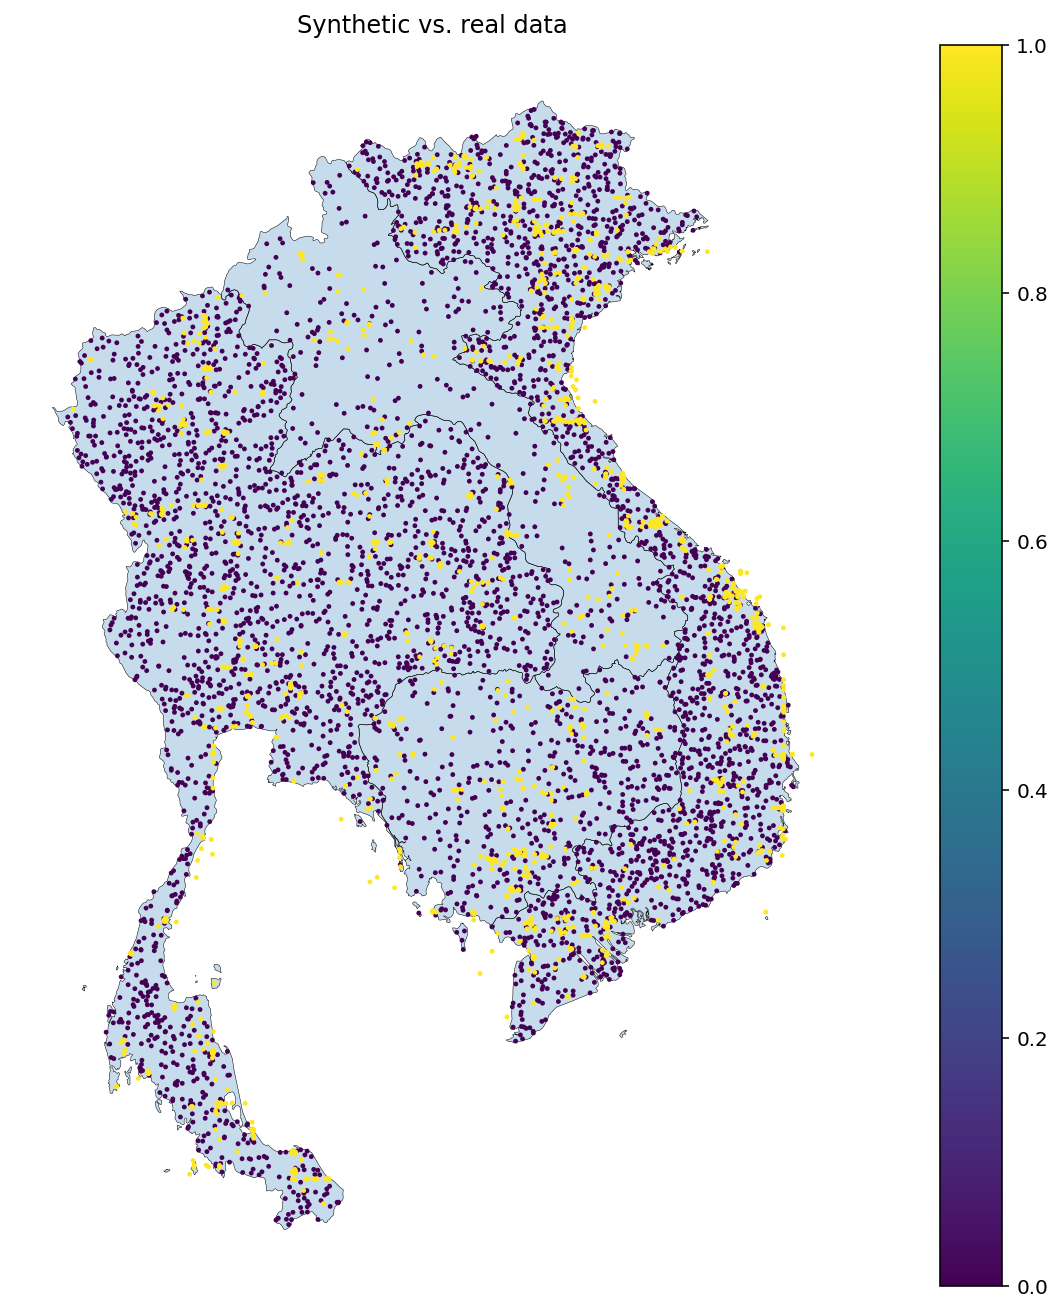

In [16]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @laos_neighboors').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

sea_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [17]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(sea_df["is_disaster"])
ISO_idx, ISO = pd.factorize(sea_df["ISO"]) 
obs_idx = sea_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(sea_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')


#Set coords
coords_sea = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }


In [18]:
with pm.Model(coords=coords_sea) as model_sea_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df_stand[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    
    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))


    p = HSGP_component
    
    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')


C:\Users\camil\AppData\Local\Temp\ipykernel_35736\1006271815.py:10: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [19]:
sample_kwargs =  {"nuts_sampler": "nutpie", "nuts_sampler_kwrags": {"backend": "jax", "gradient_backend": "jax"  } }
model_sea_1_hsgp_idata = sample_or_load( fp = "../model_sea_HSGP_2.idata", model =  model_sea_1_hsgp, sample_kwargs = sample_kwargs)

### Sea predictions

In [20]:
# We sample the predictions
with model_sea_1_hsgp.copy() as temp_model_2:
    pm.set_data({"X_gp": sea_point_grid[["lat", "lon"]],
                 "Y": np.full(sea_df_stand.shape[0], 0 ),
                 "X": sea_df_stand[features_stand],
                },
            coords= {"obs_idx": sea_df_stand.index.values } 
           )

    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model_2["HSGP_component"] ))



with freeze_dims_and_data(temp_model_2):
    model_sea_1_hsgp_plot_idata = pm.sample_posterior_predictive(model_sea_1_hsgp_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

Sampling: []


Output()

In [21]:
# Create the geopandas version of the predictions
sea_model_HSGP_predictions = prediction_to_gpd_df(prediction_idata = model_sea_1_hsgp_plot_idata , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = sea_point_grid )

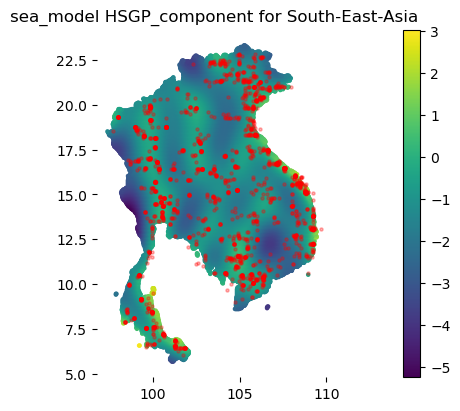

In [22]:
# Plot the predictions
fig, ax = plt.subplots()
sea_model_HSGP_predictions["HSGP_component"].plot("HSGP_component",legend=True, ax=ax ,markersize =5)
sea_disasters.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
ax.set_title("sea_model HSGP_component for South-East-Asia" );

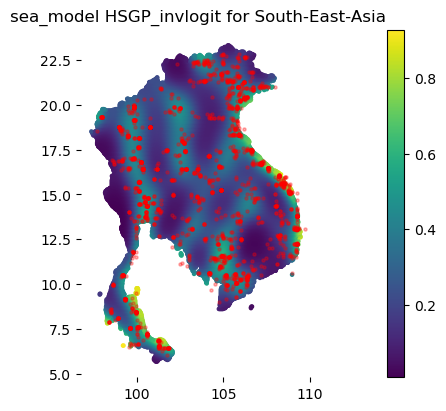

In [23]:
# Plot the predictions
fig, ax = plt.subplots()
sea_model_HSGP_predictions["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax,markersize =5)
sea_disasters.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("sea_model HSGP_invlogit" )
ax.set_title("sea_model HSGP_invlogit for South-East-Asia" );

### Laos predictions

In [24]:
# We sample the predictions
with model_sea_1_hsgp.copy() as temp_model_3:
    pm.set_data({"X_gp": laos_point_grid[["lat", "lon"]],
                 "Y": np.full(lao_df_stand.shape[0], 0 ),
                 "X": lao_df_stand[features_stand],
                },
            coords= {"obs_idx": lao_df_stand.index.values } 
           )

    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model_3["HSGP_component"] ))



with freeze_dims_and_data(temp_model_3):
    model_sea_hsgp_plot_lao_idata = pm.sample_posterior_predictive(model_sea_1_hsgp_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

Sampling: []


Output()

In [25]:
# Create the geopandas version of the predictions
sea_model_HSGP_predictions_lao = prediction_to_gpd_df(prediction_idata = model_sea_hsgp_plot_lao_idata , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = laos_point_grid )

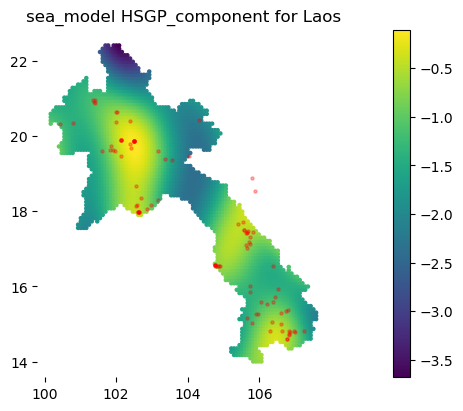

In [26]:
# Plot the predictions
fig, ax = plt.subplots()
sea_model_HSGP_predictions_lao["HSGP_component"].plot("HSGP_component",legend=True, ax=ax ,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
ax.set_title("sea_model HSGP_component for Laos" );

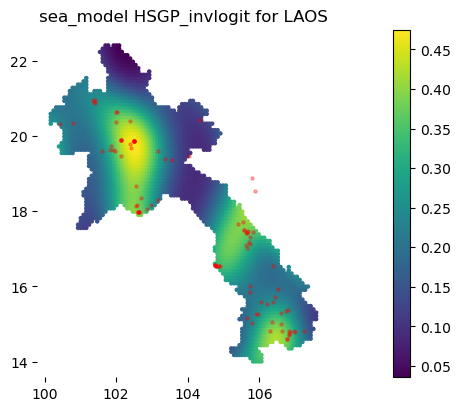

In [27]:
# Plot the predictions
fig, ax = plt.subplots()
sea_model_HSGP_predictions_lao["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("sea_model HSGP_invlogit" )
ax.set_title("sea_model HSGP_invlogit for LAOS" );

# Model on the SEA data set: Full model

In [128]:
with pm.Model(coords=coords_sea) as model_sea_full:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )
    is_island = pm.Data("is_island",  sea_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))


    #Model mu
    mu = pm.Deterministic("mu",
        country_effect[ISO_idx] + 
        (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    # p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = mu, observed=Y, dims='obs_idx')

C:\Users\camil\AppData\Local\Temp\ipykernel_35736\4062179706.py:19: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [130]:
 az.to_netcdf(data = model_sea_full_idata, filename= pathlib.Path("model_sea_full_3.idata"))

WindowsPath('model_sea_full_3.idata')

In [37]:
sample_kwargs =  {"nuts_sampler": "nutpie", "nuts_sampler_kwrags": {"backend": "jax", "gradient_backend": "jax"  } }
model_sea_full_idata = sample_or_load( fp = "../model_sea_full_3.idata", model =  model_sea_1_hsgp, sample_kwargs = sample_kwargs)

### SEA predictions

In [38]:
#Define cooords
ISO_predict_idx, ISO_predict = pd.factorize(sea_point_grid_extended["ISO"]) 
obs_idx_predict = sea_point_grid_extended.index


#Set coords
coords_sea["obs_idx_predict"] = obs_idx_predict
coords_sea["ISO_predict"] = ISO_predict

In [59]:
# full model predictions
sea_grid_2d = np.array(sea_point_grid_extended[["lat", "lon"]])

with pm.Model(coords=coords_sea) as model_sea_full_plot:
    #Declare data
    sea_is_island = sea_point_grid_extended["is_island"]
    sea_distances = sea_point_grid_extended[["log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]]
    time_varying_features_2020 =np.array(sea_point_grid_extended[time_varying_features_stand]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    country_effect = pm.Flat("country_effect", dims = ["ISO"])

    # HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=sea_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    

    point_prediction = pm.Deterministic("point_prediction", 
                         country_effect[ISO_predict_idx] 
                        + (is_island_beta * sea_is_island) 
                        + (beta[0] * sea_distances["log_distance_to_river__standardized"] ) + (beta[1] * sea_distances["log_distance_to_coastline__standardized"])
                        + f_plot
                        +  ( time_varying_features_2020 @ beta[2:])
                          )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_sea_full_plot_idata = pm.sample_posterior_predictive(
        model_sea_full_idata, var_names= ["point_prediction", "point_probability"]
    ) 

Sampling: []


Output()

In [48]:
# Create the geopandas version of the predictions
model_sea_full_predictions_geo = prediction_to_gpd_df(prediction_idata = model_sea_full_plot_idata , 
                     variables = ["point_prediction", "point_probability"] , 
                     points = sea_point_grid_extended )

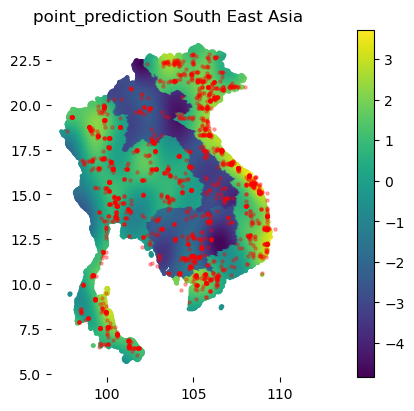

In [49]:
#Plot the predictions
fig, ax = plt.subplots()
model_sea_full_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction South East Asia", );

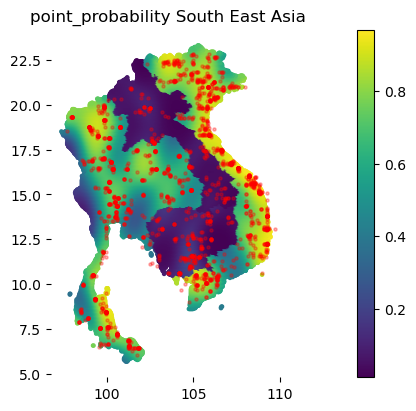

In [50]:
fig, ax = plt.subplots()
model_sea_full_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability South East Asia", );

The difference for Cambodia and Vietnam is caused by the country effects, caused by the difference in the number of events

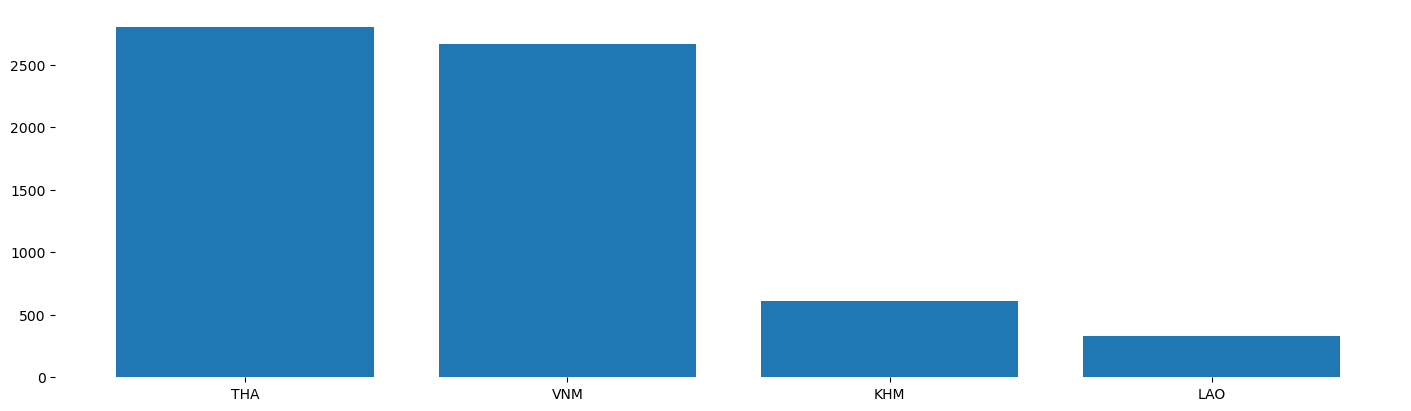

In [82]:
plt.bar(height=sea_df["ISO"].value_counts().values, x = sea_df["ISO"].value_counts().index );

### Laos predictions

In [ ]:
with pm.Model(coords=coords_sea) as model_sea_full:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )
    is_island = pm.Data("is_island",  sea_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))


    #Model mu
    mu = pm.Deterministic("mu",
        country_effect[ISO_idx] + 
        (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    # p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = mu, observed=Y, dims='obs_idx')

In [164]:
temp_model_4.debug()

point={'country_effect': array([0., 0., 0., 0.]), 'beta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), "'is_island'": array(1.), 'eta_log__': array(0.69314718), 'ell_log__': array([1.09675886, 1.09675886]), 'basis_coeffs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 

In [163]:
# We sample the predictions

laos_country_effect = model_sea_full_idata.posterior["country_effect"].mean(dim = ["chain", "draw"])[1].values

with model_sea_full.copy() as temp_model_4:
    pm.set_data({"X_gp": laos_point_grid_extended[["lat", "lon"]],
                 "Y": np.full(laos_point_grid_extended.shape[0], 0 ),
                 "X": laos_point_grid_extended[features_stand],
                 "is_island": np.full(laos_point_grid_extended.shape[0], False ), 
                 # "country_effect" : np.full(laos_point_grid_extended.shape[0], laos_country_effect )
                },
            coords= {"obs_idx": laos_point_grid_extended.index.values } 
           )

    laos_country_effect = pm.Data("laos_country_effect", np.full(laos_point_grid_extended.shape[0],laos_country_effect ))
    
    #Model mu
    laos_mu = pm.Deterministic("laos_mu",
        laos_country_effect + 
        (X @ beta)+ (is_island * is_island_beta) + HSGP_component)
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(temp_model_4["laos_mu"] ))


with freeze_dims_and_data(temp_model_4):
    model_sea_full_lao_idata = pm.sample_posterior_predictive(model_sea_full_idata, var_names=["laos_mu","point_probability"], 
                                                         compile_kwargs= {"mode" : "JAX" })

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x254B7E6E420>), RNG(<Generator(PCG64) at 0x254B7EA2DC0>), RNG(<Generator(PCG64) at 0x254B7F83E60>), RNG(<Generator(PCG64) at 0x254B7DA1EE0>), RNG(<Generator(PCG64) at 0x254B7DA1460>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: []


Output()

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int64[])>with<DynamicJaxprTrace>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function jax_funcified_fgraph at C:\Users\camil\AppData\Local\Temp\tmpauro5xms:1 for jit. This concrete value was not available in Python because it depends on the value of the argument gp_feature.
Apply node that caused the error: Add(laos_country_effect{[0.8926788 ... .89267886]}, DropDims{axis=1}.0, Mul.0, DropDims{axis=1}.0)
Toposort index: 52
Inputs types: [TensorType(float64, shape=(2945,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(None,))]
Inputs shapes: [(6409, 10), 'No shapes', (), (6409,), 'No shapes', (6409, 2), 'No shapes', 'No shapes', (), 'No shapes']
Inputs strides: [(8, 51272), 'No strides', (), (1,), 'No strides', (8, 51272), 'No strides', 'No strides', (), 'No strides']
Inputs values: ['not shown', {'bit_generator': 1, 'state': {'state': 2615583950772425566, 'inc': -700081181742760509}, 'has_uint32': 0, 'uinteger': 0, 'jax_state': array([ 608988094, 3389051742], dtype=uint32)}, array(10), 'not shown', {'bit_generator': 1, 'state': {'state': 1648256564504517449, 'inc': 7489481899381503458}, 'has_uint32': 0, 'uinteger': 0, 'jax_state': array([ 383764636, 3523173193], dtype=uint32)}, 'not shown', {'bit_generator': 1, 'state': {'state': -5863672045672432592, 'inc': 3513093081786577046}, 'has_uint32': 0, 'uinteger': 0, 'jax_state': array([2929724759, 1850637360], dtype=uint32)}, {'bit_generator': 1, 'state': {'state': -7462761104731506280, 'inc': -2417695434485118221}, 'has_uint32': 0, 'uinteger': 0, 'jax_state': array([2557407824, 2363521432], dtype=uint32)}, array(2), {'bit_generator': 1, 'state': {'state': 4949907504691338711, 'inc': -4151280962787781354}, 'has_uint32': 0, 'uinteger': 0, 'jax_state': array([1152490150, 1479204311], dtype=uint32)}]
Outputs clients: [[output[0](laos_mu), Sigmoid(laos_mu)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
    result = self._run_cell(
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
    result = runner(coro)
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\camil\AppData\Local\Temp\ipykernel_35736\2679444331.py", line 25, in <module>
    with freeze_dims_and_data(temp_model_4):
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pymc\model\transform\optimization.py", line 104, in freeze_dims_and_data
    new_outs = clone_replace(old_outs, replace=frozen_replacements, rebuild_strict=False)  # type: ignore[arg-type]

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [59]:
# full model predictions
sea_grid_2d = np.array(sea_point_grid_extended[["lat", "lon"]])

with pm.Model(coords=coords_sea) as model_sea_full_plot:
    #Declare data
    sea_is_island = sea_point_grid_extended["is_island"]
    sea_distances = sea_point_grid_extended[["log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]]
    time_varying_features_2020 =np.array(sea_point_grid_extended[time_varying_features_stand]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    country_effect = pm.Flat("country_effect", dims = ["ISO"])

    # HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=sea_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    

    point_prediction = pm.Deterministic("point_prediction", 
                         country_effect[ISO_predict_idx] 
                        + (is_island_beta * sea_is_island) 
                        + (beta[0] * sea_distances["log_distance_to_river__standardized"] ) + (beta[1] * sea_distances["log_distance_to_coastline__standardized"])
                        + f_plot
                        +  ( time_varying_features_2020 @ beta[2:])
                          )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_sea_full_plot_idata = pm.sample_posterior_predictive(
        model_sea_full_idata, var_names= ["point_prediction", "point_probability"]
    ) 

Sampling: []


Output()